In [4]:
import numpy as np
import pandas as pd
import cv2 as cv 
#from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt
import matplotlib.patches as patches
from tqdm import tqdm
import os 

import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

label_train_dir = '/home/wg49/ctmc/data/YOLO/labels/train/'

image_train_dir = '/home/wg49/ctmc/data/YOLO/images/train/'


train_dir = '/home/wg49/ctmc/data/CTMCCVPR20/train/'
codes = sorted(os.listdir(train_dir))

In [5]:
train_seq = ['3T3-run01','3T3-run03',
 'A-10-run01','A-10-run03',
 'APM-run01',
 'BPAE-run01','BPAE-run03',
 'CRE-BAG2-run01',
 'CV-1-run01',
 'LLC-MK2-run01','LLC-MK2-run02a',
 'MDBK-run01','MDBK-run03',
 'MDOK-run01','MDOK-run03',
 'OK-run01','OK-run03',
 'PL1Ut-run01',
 'RK-13-run01',
 'U2O-S-run03'
            ]
test_seq = [c for c in codes if not c in train_seq]

In [6]:
print("sequences for YOLO training:\n {}\nfor YOLO testing:\n {}".format(train_seq, test_seq))

sequences for YOLO training:
 ['3T3-run01', '3T3-run03', 'A-10-run01', 'A-10-run03', 'APM-run01', 'BPAE-run01', 'BPAE-run03', 'CRE-BAG2-run01', 'CV-1-run01', 'LLC-MK2-run01', 'LLC-MK2-run02a', 'MDBK-run01', 'MDBK-run03', 'MDOK-run01', 'MDOK-run03', 'OK-run01', 'OK-run03', 'PL1Ut-run01', 'RK-13-run01', 'U2O-S-run03']
for YOLO testing:
 ['3T3-run05', '3T3-run07', '3T3-run09', 'A-10-run05', 'A-10-run07', 'A-549-run03', 'APM-run03', 'APM-run05', 'BPAE-run05', 'BPAE-run07', 'CRE-BAG2-run03', 'CV-1-run03', 'LLC-MK2-run03', 'LLC-MK2-run05', 'LLC-MK2-run07', 'MDBK-run05', 'MDBK-run07', 'MDBK-run09', 'MDOK-run05', 'MDOK-run07', 'MDOK-run09', 'OK-run05', 'OK-run07', 'PL1Ut-run03', 'PL1Ut-run05', 'RK-13-run03', 'U2O-S-run05']


In [7]:
def get_gt(code):
  return pd.read_csv("{}{}/gt/gt.txt".format(train_dir, code, ), \
                     names=["frame", "id", "bb_left", "bb_top", "bb_width", "bb_height", "conf", "x", "y", "z"])
def get_tra(code):
  return pd.read_csv("{}{}/TRA/man_track.txt".format(train_dir, code, ), \
                     names=["track_id", "begin_track", "end_track", "parent_track"], \
                     delimiter=" ")
import configparser
config = configparser.ConfigParser()

def get_ini(code):
    config.read("{}{}/seqinfo.ini".format(train_dir, code))
    return config['Sequence']['seqLength']
def get_img(code, frame):
   return io.imread("{}{}/img1/{:06}.jpg".format(train_dir, code, frame))
def emit_image(code, gt, frame):
    pass

code = '3T3-run01'
gt = get_gt(code)
    

In [8]:
gt[gt['frame'] == 1]

,frame,id,bb_left,bb_top,bb_width,bb_height,conf,x,y,z
0,1,1,73,11,106,214,1,-1,-1,NaN
920,1,2,160,185,145,130,1,-1,-1,NaN


In [52]:
import matplotlib.patches as patches
def display_frames_bound(code, frames):
  files = ["{}{}/img1/{:06}.jpg".format(train_dir, code, i) for i in frames]

  gt = get_gt(code)
  objs_list = [gt[gt.frame == i][["bb_left", "bb_top", "bb_width", "bb_height"]].to_numpy() for i in frames]
  #print(rect)
  columns,rows = 2,2
  fig, axes =plt.subplots(columns, rows,figsize=(12, 12))
  
  for i,ax in enumerate(axes.ravel()):
      im = io.imread( files[i] )
      for obj in objs_list[i]:
          x,y,w,h = obj
          # print(x,y,w,h)
          # Create a Rectangle patch
          # print(im.shape)
          rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
          # Add the patch to the Axes
          ax.add_patch(rect)

      ax.imshow(im)

      ax.title.set_text("Frame = {}".format(frames[i]))

  fig.suptitle("Frames {}-{} w/ step {} for {}".format(min(frames), frames[i], (frames[i] - min(frames))/i, code), fontsize = 20)
  plt.show()


## Step 1. Generate data for YOLO training / testing
We will sample images and their gt bounding boxes at 50 frame intervals from all the training and test sequences. These will be fed to a YOLOv5 detector, which will train it with a YOLOv5s model pretrained on pedestrain data.

In [7]:
def label_for_frame(gt, frame, label_dir):
    
    return gt[["class", "bb_xcenter", "bb_ycenter", "bb_width", "bb_height"]].to_csv(header=False, index=False, sep=' ')

def sample_label(seq, n, label_dir):
    nframe = int(get_ini(seq))
    step = nframe // n
    gt = get_gt(seq)
    gt["bb_xcenter"] = gt["bb_left"] + gt["bb_width"] * 0.5
    gt["bb_ycenter"] = gt["bb_top"] + gt["bb_height"] * 0.5
    IMWIDTH, IMHEIGHT = 400, 320
    for field in ["bb_xcenter", "bb_width"]:
        gt[field] = gt[field] / IMWIDTH
    for field in ["bb_ycenter", "bb_height"]:
        gt[field] = gt[field] / IMHEIGHT
    gt["class"] = 0
    
    for frame in range(1, nframe + 1, step):
        csv = label_for_frame(gt[gt.frame == frame], frame, label_dir)
        filename = '{}/{}-{:06d}.txt'.format(label_dir, seq, frame)
        with open(filename, 'w') as f: 
            f.write(csv)
            #print("writing ", csv, " to ", filename)
     
import shutil
def sample_img(seq, n, image_dir):
    nframe = int(get_ini(seq))
    step = nframe // n
    for frame in range(1, nframe + 1, step):
        src = "{}/{}/img1/{:06}.jpg".format(train_dir, seq, frame)
        dst = "{}/{}-{:06}.jpg".format(image_dir, seq, frame)
        shutil.copy(src, dst)
 
label_test_dir = '/home/wg49/ctmc/data/YOLO/labels/test/'
image_test_dir = '/home/wg49/ctmc/data/YOLO/images/test/'
def generate_training():
    for seq in tqdm(train_seq):
        sample_label(seq, 100, label_train_dir)
        sample_img(seq, 100, image_train_dir)
        
    #for seq in tqdm(test_seq):
    #    sample_label(seq, 50, label_test_dir)
    #    sample_img(seq, 50, image_test_dir)

#generate_train_test() 

100%|██████████| 27/27 [00:32<00:00,  1.22s/it]


In [69]:
def generate_test():
    # for each seq, 

2062


In [8]:
def sample_label_debug(seq, n, label_dir):
    nframe = int(get_ini(seq))
    step = nframe // n
    gt = get_gt(seq)
    gt["bb_xcenter"] = gt["bb_left"] + gt["bb_width"] * 0.5
    gt["bb_ycenter"] = gt["bb_top"] + gt["bb_height"] * 0.5
    IMWIDTH, IMHEIGHT = 400, 320
    for field in ["bb_xcenter", "bb_width"]:
        gt[field] = gt[field] / IMWIDTH
    for field in ["bb_ycenter", "bb_height"]:
        gt[field] = gt[field] / IMHEIGHT
    gt["class"] = 0
    
    for frame in range(1, nframe + 1, step):
        csv = label_for_frame(gt[gt.frame == frame], frame, label_dir)
        filename = '{}/{}-{:06d}.txt'.format(label_dir, seq, frame)
        #with open(filename, 'w') as f: 
        print("writing ", csv, " to ", filename)

In [9]:
#sample_label_debug('3T3-run03', 2, '')
#display_frames_bound('3T3-run03', range(1032, 1040, 1))

## Step 2. Generate training data for siamese(re-identification) network

In [59]:
def label_for_frame(gt, frame, label_dir):
    
    return gt[["class", "bb_xcenter", "bb_ycenter", "bb_width", "bb_height"]].to_csv(header=False, index=False, sep=' ')

def sample_label(seq, n, label_dir):
    nframe = int(get_ini(seq))
    step = nframe // n
    gt = get_gt(seq)
    gt["bb_xcenter"] = gt["bb_left"] + gt["bb_width"] * 0.5
    gt["bb_ycenter"] = gt["bb_top"] + gt["bb_height"] * 0.5
    IMWIDTH, IMHEIGHT = 400, 320
    for field in ["bb_xcenter", "bb_width"]:
        gt[field] = gt[field] / IMWIDTH
    for field in ["bb_ycenter", "bb_height"]:
        gt[field] = gt[field] / IMHEIGHT
    gt["class"] = 0
    
    for frame in range(1, nframe + 1, step):
        csv = label_for_frame(gt[gt.frame == frame], frame, label_dir)
        filename = '{}/{}-{:06d}.txt'.format(label_dir, seq, frame)
        with open(filename, 'w') as f: 
            f.write(csv)
            #print("writing ", csv, " to ", filename)
     
import shutil
classnames = list(np.unique([s[:s.find("-run")] for s in codes]))
def sample_crop(seq, n, crop_dir):
    nframe = int(get_ini(seq))
    step = nframe // n
    gt = get_gt(seq)
    class_ = classnames.index(seq[:seq.find("-run")])
    print("Sampling cropped image from seq {} , class {}".format(seq, class_))
    print(' saving to {}/{}/{}'.format(crop_dir, class_, "seq-frame-box"))
    for frame in range(1, nframe + 1, step):
        src = "{}/{}/img1/{:06}.jpg".format(train_dir, seq, frame)
        img = io.imread(src)
        ft = gt[gt.frame == frame]
        for idx, r in ft.iterrows():
            #x1 = r["bb_xcenter"] - r["bb_width"] * 0.5
            #x2 = r["bb_xcenter"] + r["bb_width"] * 0.5
            #y1 = r["bb_ycenter"] - r["bb_height"] * 0.5
            #y2 = r["bb_ycenter"] + r["bb_height"] * 0.5
            x1 = r["bb_left"]
            x2 = r["bb_left"] + r["bb_width"]
            y1 = r["bb_top"]
            y2 = r["bb_top"] + r["bb_height"]
            x1, x2, y1, y2 = int(x1+.5), int(x2+.5), int(y1+.5),int(y2 +.5)
            x1 = max(0, x1)
            y1 = max(0, y1)
            #x2 = min(x2, 399)
            #y2 = min(y2, 319)
            #print(x1, x2, y1, y2)
            if x1 >= x2 or y1 >= y2:
                continue

            crop = img[y1:y2+1, x1: x2+1]
            name = "{}-{:06}-{:02}.jpg".format(seq, frame, idx+1)
            savedir = '{}/{}/'.format(crop_dir, class_)
            if not os.path.exists(savedir):

                os.makedirs(savedir)
            #print(x1, x2, y1, y2, crop)
            io.imsave('{}/{}/{}'.format(crop_dir, class_, name), crop )
                      
siamese_train_dir = '/home/wg49/ctmc/data/siamese/crops'
siamese_test_dir = '/home/wg49/ctmc/data/siamese/crops_test'

def gen_siamese():
    #for seq in tqdm( train_seq ) : # ['OK-run03', 'PL1Ut-run01', 'RK-13-run01', 'U2O-S-run03'] ) : #train_seq):
    #    sample_crop(seq, 10, siamese_train_dir)
        
    for seq in tqdm(test_seq):
        sample_crop(seq, 5, siamese_test_dir)


In [ ]:
gen_siamese()

## Step 3. Train YOLO 
There are 2099 training images generated from 20 training sequences.

Go to yolov5/ and run the following
```
python train.py --batch 16 --epochs 5 --data /home/wg49/ctmc/data/YOLO/ctmc.yaml \
--weights yolov5m.pt --cache \
--single-cls  \
--project ctmc-train-m1

```
old weights at /home/wg49/ctmc/yolov5/runs/train/exp4/weights/best.pt

In [2]:
import sys
yolo_path = '/home/wg49/ctmc/yolov5'
if yolo_path not in sys.path:
    sys.path.append(yolo_path)
from utils.plots import plot_results 

In [7]:
plot_results(save_dir='/home/wg49/ctmc/yolov5/ctmc-train-m/exp')  # plot results.txt as results.png

## Step 4. Run YOLO on test sequences

1. generate all ctmc-SEQ.yaml files.

In [26]:
def gen_yaml(seq):
    target_path = '/home/wg49/ctmc/data/YOLO/ctmc-{}.yaml'.format(seq)
    val_dir = '/home/wg49/ctmc/data/CTMCCVPR20/train/{}/img1'.format(seq)
    template = """train: /home/wg49/ctmc/data/YOLO/images/train
val:  {val_dir} 

# number of classes
nc: 1

# class names
names: [ 'cell' ]
"""
    yaml_content = template.format(val_dir = val_dir)
    with open(target_path, 'w') as f:
        f.write(yaml_content)
        
for seq in test_seq:
    gen_yaml(seq)

2. Goto yolov5 and run ../scripts/test.sh --name seq. This will generate detection on all images in that sequence and store them in /home/wg49/ctmc/CTMC-project/yolov5/ctmc-runs/seq/exp/labels/ .


In [ ]:
for filename in $(head -n 1 ../test_seq.txt); do \
seq=$(basename $filename); \
echo "===== generating YOLO detection on $seq ====="; \
python /home/wg49/ctmc/yolov5/test.py --data /home/wg49/ctmc/data/YOLO/ctmc-$seq.yaml --img-size 400 --save-txt \
  --batch-size 32 --save-conf --conf-thres 0.3 --single-cls  --weights /home/wg49/ctmc/yolov5/runs/train/exp4/weights/best.pt \
  --project ctmc-runs --verbose --name $seq --exist-ok; \
done; \

In [ ]:
%%bash
# /home/wg49/ctmc/yolov5/ctmc-train-m/exp/weights/best.pt
# /home/wg49/ctmc/yolov5/runs/train/exp4/weights/best.pt
#$(cat ../test_seq.txt);
cd yolov5;
for filename in 3T3-run05; do \
seq=$(basename $filename); \
echo "===== generating YOLO detection on $seq ====="; \
python /home/wg49/ctmc/yolov5/test.py --data /home/wg49/ctmc/data/YOLO/ctmc-$seq.yaml --img-size 400 --save-txt \
  --batch-size 32 --save-conf --conf-thres 0.3 --single-cls  --weights /home/wg49/ctmc/yolov5/ctmc-train-m/exp/weights/best.pt \
  --project ctmc-runs-m --verbose --name $seq --exist-ok; \
done; \
cd ../;

3. Transform the detection result into Deepsort format (MOT challenge format),
Deepsort is gonna read a mot-dir, which contains our images, and a detect-dir, which contais our predictions

In [ ]:
%%bash
# HERE use MOT challenge format because deepsort needs to stick to it in preprocessing
#
#<frame>, <id>, <bb_left>, <bb_top>, <bb_width>, <bb_height>, <conf>, <x>, <y>, <z>

#We can fill x, y, z with -1 because this is a 2D challenge.

python ./scripts/move_yolo_here.py

## Step 5. Extract detection features for Deepsort 

In [6]:
%%bash
set -e; \
for filename in $(cat test_seq.txt); do \
  seq=$(basename $filename); \
  echo "===== generating detection on $seq ====="; \
    python ./tools/generate_detections.py \
        --model=resources/networks/mars-small128.pb \
        --mot_dir=./data/CTMCCVPR20/train \
        --output_dir=./resources/detections/CTMCCVPR20 \
        --detection_dir=./data/YOLO/detections/$seq; \
done;

Process is terminated.


## Step 6. Run Deepsort with detection file

In [ ]:
# Run Tracker on one sequence, given the detection in step 1
# produces tracking result (object and its bounding box at each frame)
! python deep_sort_app.py \
    --sequence_dir=./data/CTMCCVPR20/train/3T3-run05 \
    --detection_file=./resources/detections/CTMCCVPR20/3T3-run05.npy \
    --min_confidence=0.4 \
    --max_cosine_distance=0.07 \
    --lambda=0.1\
    --nn_budget=100 \
    --display=True \
    --output_file=./resources/predictions/train_yolo_tmp/3T3-run05.txt

### Step 6.1. Hyperparameter tuning
Confidence, lambda, max cosine distance, and window

In [ ]:
c=0.4; \
l=0.1; \
d=0.1; \
w=100; \
set -e; \
for filename in $(cat test_seq.txt); do \
  seq=$(basename $filename); \
  echo "running tracker on $seq"; \
  python deep_sort_app.py \
    --sequence_dir=./data/CTMCCVPR20/train/"$seq" \
    --detection_file=./resources/detections/CTMCCVPR20/"$seq".npy \
    --min_confidence=$c \
    --max_cosine_distance=$d \
    --lambda=$l \
    --nn_budget=$w \
    --display=False \
    --output_file=./resources/predictions/train_yolo/"$seq".txt; \
done; 

In [ ]:
# Run Tracker on one sequence
# original: max consine distance 0.5, not good
#l = 0.1 or 0.9
# good: l0.1, c0.4,d0.1 shows high IDF1!!!
# note : bounding box is a rect . this might be flawed compared to a mask.!!
%%shell
for l in 0.1; do \
for c in 0.4; do \
for d in 0.03 0.05; do \
for w in 100; do \
for filename in data/YOLO/detections/*; do \
  seq=$(basename $filename); \
  echo "running tracker on $seq"; \
  python deep_sort_app.py \
    --sequence_dir=./data/CTMCCVPR20/train/"$seq" \
    --detection_file=./resources/detections/CTMCCVPR20/"$seq".npy \
    --min_confidence=$c \
    --max_cosine_distance=$d \
    --lambda=$l \
    --nn_budget=$w \
    --display=False \
    --output_file=./resources/predictions/train_yolo_d2/"$seq".txt; \
done; \
cp -r ./resources/predictions/train_yolo_d2/* \
  ./TrackEval/data/trackers/mot_challenge/ctmc-train/deepsort/data/; \
python TrackEval/scripts/run_mot_challenge.py --BENCHMARK ctmc --SPLIT_TO_EVAL train \
  --TRACKERS_TO_EVAL deepsort --DO_PREPROC False > final_result_l"$l"_c"$c"_d"$d"_w"$w".txt; \
done; \
done; \
done; \
done;

## Step 6.2. Run deepsort on siamese network trained for cells

In [ ]:
%%shell
for filename in data/YOLO/detections/*; do \
  seq=$(basename $filename); \
  if [[ $seq -eq 3T3-run05 ]]; then \
    continue; \
  fi;
  echo "running tracker on $seq"; \
  python run.py \
    --sequence_dir=../data/CTMCCVPR20/train/$seq \
    --detection_file=../data/YOLO/detections/$seq/gt/gt.txt  \
    --model=/home/wg49/ctmc/nanonets_object_tracking/ckpts/ctmc7.pt \
    --min_confidence=0.4 \
    --max_cosine_distance=0.1 \
    --lambda=0.1 \
    --nn_budget=100 \
    --display=True \
    --output_file=../resources/predictions/train_yolo/$seq.txt; \
done;

In [ ]:
for filename in ../data/YOLO/detections/*; do \
  seq=$(basename $filename); \
  echo "running tracker on $seq"; \
  python run.py \
    --sequence_dir=../data/CTMCCVPR20/train/$seq \
    --detection_file=../data/YOLO/detections/$seq/gt/gt.txt  \
    --model=/home/wg49/ctmc/nanonets_object_tracking/ckpts/ctmc7.pt \
    --min_confidence=0.4 \
    --max_cosine_distance=0.1 \
    --lambda=0.1 \
    --nn_budget=100 \
    --display=True \
    --output_file=../resources/predictions/train_yolo/$seq.txt; \
done; \
cd ../; \
cp -r ./resources/predictions/train_yolo/* \
  ./TrackEval/data/trackers/mot_challenge/ctmc-train/deepsort/data/; \
python TrackEval/scripts/run_mot_challenge.py --BENCHMARK ctmc --SPLIT_TO_EVAL train \
  --TRACKERS_TO_EVAL deepsort --DO_PREPROC False > result_siam.txt;



In [ ]:
# Step 4.
cp -r ./resources/predictions/train/* ./TrackEval/data/trackers/mot_challenge/ctmc-train/deepsort/data/
cp -r ./resources/predictions/train_yolo/* ./TrackEval/data/trackers/mot_challenge/ctmc-train/deepsort/data/
python TrackEval/scripts/run_mot_challenge.py --BENCHMARK ctmc --SPLIT_TO_EVAL train \
  --TRACKERS_TO_EVAL deepsort --DO_PREPROC False

## Visualizing tracking result

In [33]:
detect_dir = '/home/wg49/ctmc/CTMC-project/yolov5/runs/test/exp4/labels/'
def get_detection(code, frame):
  return pd.read_csv("{}/{}-{:06}.txt".format(detect_dir, code, frame), \
                     names=["class", "bb_xcenter", "bb_ycenter", "bb_width", "bb_height", "conf"], sep=" ")

def display_detection_frames(code, frames, conf=0.25):
  #print(rect)
  columns,rows = 4, 4
  fig, axes =plt.subplots(columns, rows,figsize=(12, 12))
  W,H = 400,320
  for i,ax in enumerate(axes.ravel()):
      frame = frames[i]
      pred = get_detect(code, frame)
      pred = pred[pred.conf > conf]
      filename = "{}{}/img1/{:06}.jpg".format(train_dir, code, frame)
      im = io.imread( filename )

      bboxes = pred[["bb_xcenter", "bb_ycenter", "bb_width", "bb_height"]].to_numpy()
      for bbox in bboxes:
          xc,yc,w,h = bbox
          xc,yc,w,h = xc*W , yc*H, w*W, h*H
          # print(x,y,w,h)
          # Create a Rectangle patch
          # print(im.shape)
          rect = patches.Rectangle((xc - w / 2, yc - h / 2), w, h, linewidth=1, edgecolor='r', facecolor='none')
          # Add the patch to the Axes
          ax.add_patch(rect)

      ax.imshow(im)

      ax.title.set_text("Frame = {}".format(frame))
        
      if i + 1 == len(frames):
          break

  #fig.suptitle("Frames {}-{} w/ step {} for {}".format(min(frames), frames[i], (frames[i] - min(frames))/i, code), fontsize = 20)
  plt.show()


In [34]:
get_detection('3T3-run05', 1)

,class,bb_xcenter,bb_ycenter,bb_width,bb_height,conf
0,0,0.795783,0.689759,0.165060,0.207831,0.730957
1,0,0.851506,0.205525,0.296988,0.202654,0.727051
2,0,0.053012,0.264684,0.097892,0.196536,0.686523
3,0,0.071950,0.632530,0.138630,0.250000,0.638184
4,0,0.893373,0.843373,0.190361,0.283133,0.632324
...,...,...,...,...,...,...
295,0,0.006382,0.705196,0.012764,0.184488,0.001245
296,0,0.000000,0.581325,0.000000,0.225151,0.001244
297,0,0.743976,0.232869,0.116867,0.134413,0.001243
298,0,0.000000,0.291416,0.000000,0.167169,0.001228


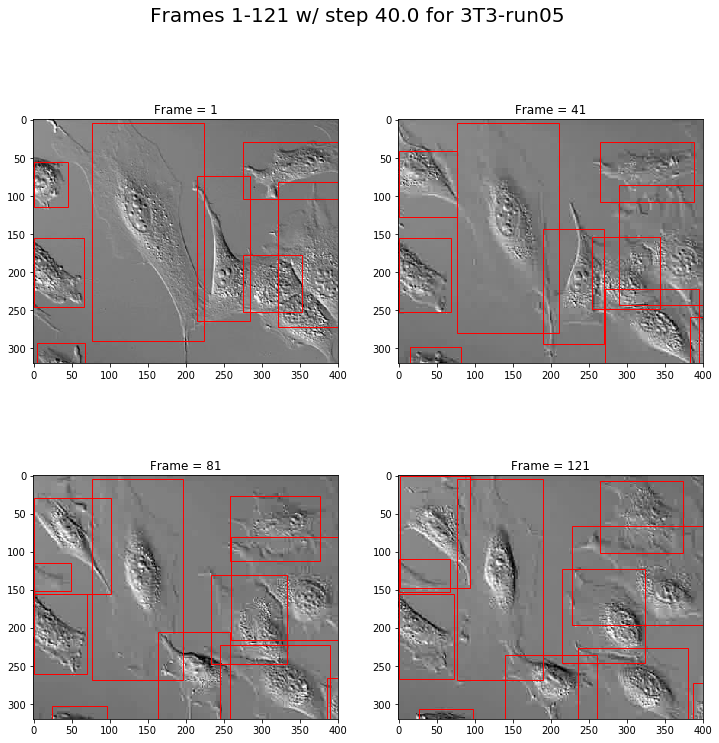

In [53]:
#get_detect('3T3-run05', 1)
display_frames_bound('3T3-run05', range(1,1000, 40))
#display_detection_frames('BPAE-run07', range(1,1000, 43))

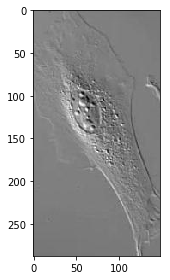

In [54]:
io.imshow('/home/wg49/ctmc/data/siamese/crops_test/0/3T3-run05-000001-01.jpg')

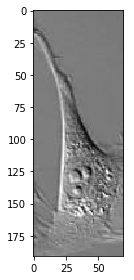

In [55]:
io.imshow('/home/wg49/ctmc/data/siamese/crops_test/0/3T3-run05-000001-1587.jpg')